# Climate Change

![](img/stevenson.jpg)    
$^{1}$Image credit: [MysteryShot](https://www.istockphoto.com/es/portfolio/MysteryShot?mediatype=photography) via [iStock](https://www.istockphoto.com/es)

Mar, 2023
> *Exploratory Analysis, Statistical Hypothesis testing*

## Background
Climate is changing, we all know that. There is no doubt temperatures are rising and weather patterns are shifting. Science repeatedly confirms that.

Besides, when I was a kid, I remember winters were colder and it used to rain more.   
But wait! This is now my memory talking. And I know it can be misleading. Where really colder and rainier those distant days in the seventies and eighties?

There is no doubt about the global warming, but is it also happening in my town?   
I wanted to check it out by myself.

In [29]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import my_functions as my
from IPython.display import Markdown

## The data
I headed for the website of the Spanish national weather agency [AEMET](https://www.aemet.es/es/datos_abiertos/AEMET_OpenData), where open data can be downloaded. There is a weather station right in my town, so I selected it, but only data from 2008 onwards was available. So I chose instead the main station in the province, the meteorological observatory in Igueldo (San Sebastian).

![Igeldo](img/igeldo.jpg)   
$^{1}$Image credit: [AEMET](https://www.aemet.es)

This historical observatory started working in 1905, and the available data spans from 1928, so it holds the second longest weather data series in Spain. I also learned from the internet that measurement methods have not changed since then, and that made the data very valuable and this observatory a member of the international organization for the study of the climate change.

In [30]:
# Init
dates = []
temperatures = []
rainfalls = []

# Iterate through years
for year in range(1928, 2023):
    
    # Read json file
    with open(f"data/aemet/aemet-ss-{year}.json", encoding='utf-8') as file:
        data = json.load(file)

   # Iterate through months of the year
    for month in range(12):
        
        # Fetch average monthly temperature
        if 'tm_mes' in data[month]:
            temperature = float(data[month]['tm_mes'])
            temperatures.append(temperature)
        else:
            temperatures.append(np.nan)
        
        # Fetch monthly rainfall
        if 'p_mes' in data[month]:
            rainfall = float(data[month]['p_mes'])
            rainfalls.append(rainfall)
        else:
            rainfalls.append(np.nan)

        # Store date
        dates.append(str(year) + "-" + str(month + 1))
        
    
# Build pandas dataframe from stored data
aemet_ss = pd.DataFrame({"temp": temperatures,
                         "rainfall": rainfalls},
                        index=dates)
aemet_ss.index = pd.to_datetime(aemet_ss.index)
aemet_ss

,temp,rainfall
1928-01-01,NaN,179.8
1928-02-01,NaN,42.0
1928-03-01,NaN,184.5
1928-04-01,NaN,115.7
1928-05-01,NaN,125.8
...,...,...
2022-08-01,21.4,76.5
2022-09-01,18.6,147.6
2022-10-01,19.6,40.6
2022-11-01,13.4,317.3


The data was downloaded as JSON files (one for each year: 95 files-years), and from them monthly average temperatures and monthly accumulated rainfalls were gathered.

## Data validation

In [31]:
# Print dataframe info
aemet_ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1140 entries, 1928-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      1132 non-null   float64
 1   rainfall  1140 non-null   float64
dtypes: float64(2)
memory usage: 26.7 KB


There are 8 month-temperatures missing.

In [32]:
# Show missing values
aemet_ss[aemet_ss["temp"].isna()]

,temp,rainfall
1928-01-01,NaN,179.8
1928-02-01,NaN,42.0
1928-03-01,NaN,184.5
1928-04-01,NaN,115.7
1928-05-01,NaN,125.8
1928-09-01,NaN,19.8
1936-09-01,NaN,77.0
1936-10-01,NaN,166.6


Temperature data is missing for six months in 1928, so I am going to remove that year altogether. Two months are also lacking data in 1936 (beginning of the Spanish War). I am going to assign them the mean value of the closest known month temperatures.

In [33]:
# Discard 1928
aemet_ss = aemet_ss[aemet_ss.index.year != 1928]

# Fill in missing 1936 months with neighbouring values
mean_value = np.mean([aemet_ss.loc['1936-08-01', 'temp'], aemet_ss.loc['1936-11-01', 'temp']])
aemet_ss = aemet_ss.fillna(mean_value)

# Print dataframe info
aemet_ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1128 entries, 1929-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      1128 non-null   float64
 1   rainfall  1128 non-null   float64
dtypes: float64(2)
memory usage: 58.7 KB


The data is now ready to proceed with the analysis.

## Temperatures
Let's start exploring the temperatures!

### Exploratory Data Analysis
I will plot yearly average temperatures together with their average value of the last 25 years. This rolling window of 25 years draws a smoother curve and allows to see possible trends.

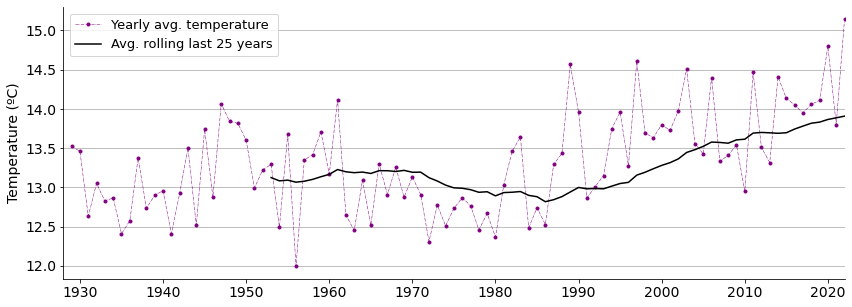

In [34]:
# Calculate yearly average temperatures
yearly_temp = aemet_ss.groupby(aemet_ss.index.year)["temp"].mean().to_frame()

# Define rolling window
window = 25 # Years

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
yearly_temp.plot(ax=ax, marker='.', linestyle="-.", linewidth=0.5, color='purple')
yearly_temp.rolling(window=window).mean().plot(ax=ax, color='black')

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.set_xticks([1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
ax.tick_params(axis='y', labelsize=14)
ax.set_title("", size=15)
ax.set_xlabel("")
ax.set_ylabel("Temperature (ºC)", size=14)
ax.legend(["Yearly avg. temperature", f"Avg. rolling last {window} years"], fontsize=13)
sns.despine()
ax.set_xlim(1928,2022)

plt.show()

Average temperatures do seem to be increasing lately according to the graph.

To evaluate the differences and proceed with the analysis, let's classify the data into three groups:
- Temperatures from the last 25 years (from 1998 to 2022)
- Temperatures from the previous last 25 years (from 1973 to 1997)
- Temperatures from the previous to the previous last 25 years (from 1948 to 1972)

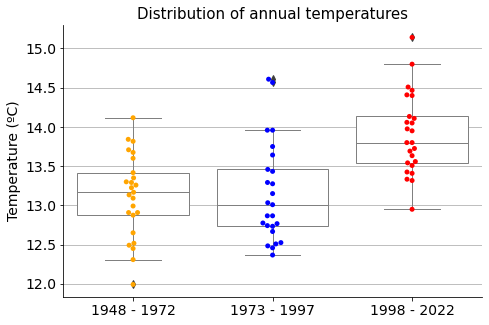


Average value 1948-1972 -> 13.12 ºC
Average value 1973-1997 -> 13.16 ºC
Average value 1998-2022 -> 13.91 ºC



In [35]:
# Split and convert to numpy array
temp_48_72 = yearly_temp.loc[1948:1972].to_numpy().flatten()
temp_73_97 = yearly_temp.loc[1973:1997].to_numpy().flatten()
temp_98_22 = yearly_temp.loc[1998:2022].to_numpy().flatten()

# Create dataframe
df_temp = pd.DataFrame({"temp_48_72": temp_48_72,
                        "temp_73_97": temp_73_97,
                        "temp_98_22": temp_98_22,
                       }).melt()

# Make bee swarm plot
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.swarmplot(ax=ax, x="variable", y="value", data=df_temp,
              hue="variable", palette=["orange", "blue", "red"])
sns.boxplot(ax=ax, x="variable", y="value", data=df_temp,
            boxprops=dict(linewidth=1, facecolor='white', edgecolor='grey', alpha=1),
                whiskerprops=dict(linewidth=1, color='grey', alpha=1),
                medianprops=dict(linewidth=1, color="grey", alpha=1),
                capprops=dict(linewidth=1, color='grey', alpha=1))

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Distribution of annual temperatures", size=15)
ax.set_xlabel("")
ax.set_ylabel("Temperature (ºC)", size=14)
ax.legend().set_visible(False)
ax.set_xticklabels(["1948 - 1972", "1973 - 1997", "1998 - 2022"], rotation=0)
sns.despine()

plt.show()

# Print mean values
print(f"\nAverage value 1948-1972 -> {np.mean(temp_48_72):.2f} ºC")
print(f"Average value 1973-1997 -> {np.mean(temp_73_97):.2f} ºC")
print(f"Average value 1998-2022 -> {np.mean(temp_98_22):.2f} ºC\n")

Relative differences seem to be remarkable between '1973-1997' and '1998-2022' groups (as expected from global warming), so I will focus on these two.

### Estimate of the difference
Let's estimate the difference in the mean value with a 95% confidence interval.

In [36]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Compute the difference of the sample means
mean_diff = np.mean(temp_98_22) - np.mean(temp_73_97)

# Get bootstrap replicates of means
bs_replicates_73_97 = my.draw_bs_reps(temp_73_97, np.mean, size=10000)
bs_replicates_98_22 = my.draw_bs_reps(temp_98_22, np.mean, size=10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_98_22 - bs_replicates_73_97

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print(f"'1998-2022' vs '1973-1997'\nDifference of the means -> {mean_diff:.2f} ºC")
print(f"95% ci = {conf_int} ºC")

'1998-2022' vs '1973-1997'
Difference of the means -> 0.75 ºC
95% ci = [0.43465833 1.064     ] ºC


How significant is this difference?

### Hypothesis testing
Are temperatures really on the rise? We are going to do hypothesis testing to evaluate it.

The null hypothesis will be that '1973-1997' and '1998-2022' data sets, they both come from the same data distribution and so the difference in the mean temperatures occurred just by chance. We will scramble the data from both sets in what is known as permutation samples to simulate this belonging to the same source.

Let's first explore visually in a ECDF (*Empirical Cumulative Distribution Function*) how permutation samples relate to the original data sets.

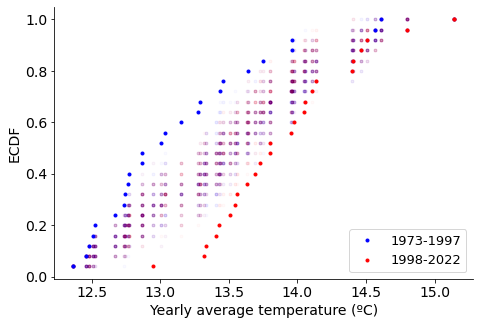

In [37]:
# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

# Number of permutation samples to draw
n_samples = 100

# Iterate
for _ in range(n_samples):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = my.permutation_sample(temp_73_97, temp_98_22)

    # Compute ECDFs
    x_1, y_1 = my.ecdf(perm_sample_1)
    x_2, y_2 = my.ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    ax.plot(x_1, y_1, marker='.', linestyle='none', color='blue', alpha=0.02)
    ax.plot(x_2, y_2, marker='.', linestyle='none', color='red', alpha=0.02)


# Now create and plot ECDFs from original data
x_1, y_1 = my.ecdf(temp_73_97)
x_2, y_2 = my.ecdf(temp_98_22)
ax.plot(x_1, y_1, marker='.', linestyle='none', color='blue', label="1973-1997")
ax.plot(x_2, y_2, marker='.', linestyle='none', color='red', label="1998-2022")

ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("", size=15)
ax.set_xlabel("Yearly average temperature (ºC)", size=14)
ax.set_ylabel("ECDF", size=14)
ax.legend(loc='lower right', fontsize=13)
sns.despine()

plt.show()

We see that permutated data sets (in hazed purple points) do not overlap with the original temperature sets, suggesting there is a significant difference among them. Let's prove it!

To test this hypothesis we will use the difference of means as the *test statistic*..

In [38]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

We will compute the probability of getting that difference under the null hypothesis that the distributions of mean temperatures of the two groups ('1973-1997' and '1998-2022') are identical. 

In [39]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Draw 10,000 permutation replicates
perm_replicates = my.draw_perm_reps(temp_98_22, temp_73_97, diff_of_means, size=10000)

# Compute p-value
p = np.sum(perm_replicates >= mean_diff) / len(perm_replicates)

display(Markdown(f"p-value = **{p}**"))

p-value = **0.0001**

The obtained p-value says that after randomly scrambling the data from the two groups 10000 times and making two groups each time, only once the difference between their mean values was equal or higher than the difference among the original groups. That is to say, the probability of observing the difference in mean temperatures if there was not such a thing as two different groups would be just of 0.01 %.

So we reject the null hypothesis and conclude that the two temperature groups are indeed different and come with different distributions, i.e. temperatures are rising.

## Rainfall
Was it rainier when I was a kid? That is what I thought. But my memories are probably skewed, maybe in part because of the awareness about the ongoing climate change, which suggests drier weather conditions nowadays.

Let's check it out!

### Exploratory Data Analysis

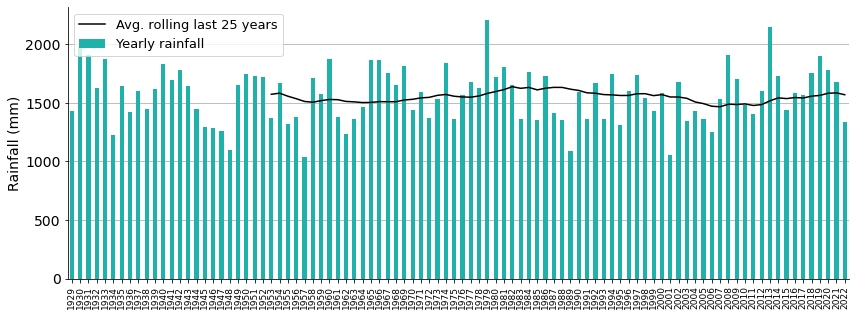

In [40]:
# Calculate yearly average rainfall
yearly_rainfall = aemet_ss.groupby(aemet_ss.index.year)["rainfall"].sum().to_frame()
yearly_rainfall_avg10 = yearly_rainfall.rolling(window=window).mean().reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(14, 5))

yearly_rainfall.plot(kind="bar", color='lightseagreen', ax=ax)
yearly_rainfall_avg10.plot(kind="line", color='black', ax=ax)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=9, rotation=90)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("", size=15)
ax.set_xlabel("")
ax.set_ylabel("Rainfall (mm)", size=14)
ax.legend([f"Avg. rolling last {window} years", "Yearly rainfall"],
          loc='upper left', fontsize=13)
sns.despine()

plt.show()

It looks like average rainfall has not changed during all these years!

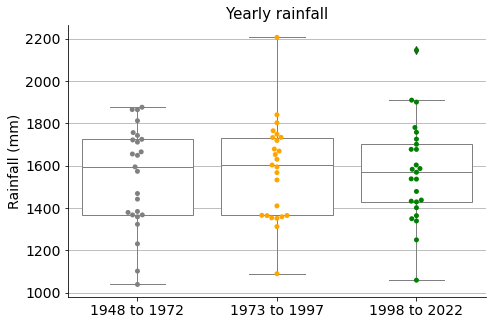

In [41]:
# Split and convert to numpy array
rain_48_72 = yearly_rainfall.loc[1948:1972].to_numpy().flatten()
rain_73_97 = yearly_rainfall.loc[1973:1997].to_numpy().flatten()
rain_98_22 = yearly_rainfall.loc[1998:2022].to_numpy().flatten()

# Create dataframe
df_rain = pd.DataFrame({"rain_48_72": rain_48_72,
                        "rain_73_97": rain_73_97,
                        "rain_98_22": rain_98_22,
                       }).melt()

# Make bee swarm plot
fig, ax = plt.subplots(figsize=(7.5, 5))
sns.swarmplot(ax=ax, x="variable", y="value", data=df_rain,
              hue="variable", palette=["grey", "orange", "green"])
sns.boxplot(ax=ax, x="variable", y="value", data=df_rain,
            boxprops=dict(linewidth=1, facecolor='white', edgecolor='grey', alpha=1),
                whiskerprops=dict(linewidth=1, color='grey', alpha=1),
                medianprops=dict(linewidth=1, color="grey", alpha=1),
                capprops=dict(linewidth=1, color='grey', alpha=1))

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Yearly rainfall", size=15)
ax.set_xlabel("")
ax.set_ylabel("Rainfall (mm)", size=14)
ax.legend().set_visible(False)
ax.set_xticklabels(["1948 to 1972", "1973 to 1997", "1998 to 2022"], rotation=0)
sns.despine()

plt.show()

If we make three groups like in the case of the temperatures, we see very similar distributions for the rainfalls. Maybe, there is a slight drop in the '1998-2022' group, at least for the median. Let's see if that is the case with mean values.

### Hypothesis testing

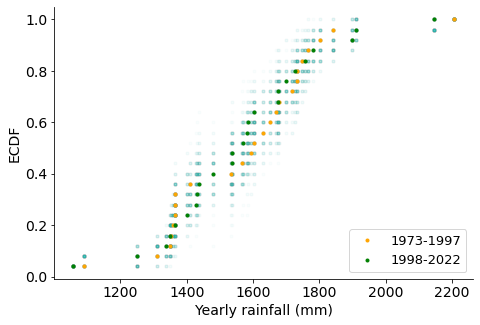

In [42]:
# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

# Number of permutation samples to draw
n_samples = 100

# Iterate
for _ in range(n_samples):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = my.permutation_sample(rain_73_97, rain_98_22)

    # Compute ECDFs
    x_1, y_1 = my.ecdf(perm_sample_1)
    x_2, y_2 = my.ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    ax.plot(x_1, y_1, marker='.', linestyle='none', color='lightseagreen', alpha=0.02)
    ax.plot(x_2, y_2, marker='.', linestyle='none', color='lightseagreen', alpha=0.02)

    
# Now create and plot ECDFs from original data
x_1, y_1 = my.ecdf(rain_73_97)
x_2, y_2 = my.ecdf(rain_98_22)
ax.plot(x_1, y_1, marker='.', linestyle='none', color='orange', label='1973-1997')
ax.plot(x_2, y_2, marker='.', linestyle='none', color='green', label='1998-2022')

ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("", size=15)
ax.set_xlabel("Yearly rainfall (mm)", size=14)
ax.set_ylabel("ECDF", size=14)
ax.legend(loc='lower right', fontsize=13)
sns.despine()

plt.show()

We see that permutated data sets (in hazed points) do overlap with the original rainfall sets (orange and green), suggesting there is not a significant difference.

In [43]:
# Compute difference of mean
empirical_diff_means = diff_of_means(rain_98_22, rain_73_97)
print(f"Empirical difference in the mean: {empirical_diff_means:.2f} mm")

Empirical difference in the mean: -8.69 mm


This slight fall in the average rainfall of '1973-1997' compared to '1998-2022', is it significant?

In [44]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Draw 10,000 permutation replicates
perm_replicates = my.draw_perm_reps(rain_98_22, rain_73_97, diff_of_means, size=10000)

# Compute p-value
p = np.sum(perm_replicates <= empirical_diff_means) / len(perm_replicates)

display(Markdown(f"p-value = **{p}**"))

p-value = **0.4443**

The obtained p-value means that after randomly scrambling the data from the two groups 10000 times and making two groups each time, 4443 times the difference between their mean values was less than or equal to the difference among the original two groups. That is to say, the probability of observing the same difference as in the empirical data in mean rainfalls is 46.01 %. Quite high, so it should be just chance.

So we fail to reject the null hypothesis and conclude that the two rainfall groups are indeed the same and come with the same distributions, i.e. there is no difference in rainfalls (so my memory was in fact skewed).

## Conclusion

In this little project permutational testing was used to assess whether temperatures and rainfalls are changing *locally* because of the climate change. I came to the conclusion that temperatures are certainly rising, and rainfalls remain the same.

One of the best things about doing Data Science is the thrill you get from collecting raw data and drawing your own conclusions. Even more if the subject is such an important and universal topic as Climate Change. You *are* doing Science, probably not high-level science, but science anyway. And it is thrilling!